This notebook implemeting all necessery process to obtain the spectra that will be used in my Doctorate degreee

In [96]:
import os
import requests
import zipfile
import json
import datetime
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# WISeREP

The main webpage is: [WISeREP](https://www.wiserep.org/)

## Download data

In [78]:
WISeREP                = "www.wiserep.org"
url_wis_spectra_search = "https://" + WISeREP + "/search/spectra"

# Specify the Personal api key here (*** MUST BE PROVIDED ***)
personal_api_key       = "9da72158cebc45da6305466dd99895b079219f6b"
# for User-Agent:
WIS_USER_NAME          = "Steve Jurado"
WIS_USER_ID            = "Steve Jurado"

In [94]:
supernovae_types = {
    1: 'SN', 2: 'SN I', 3: 'SN Ia', 4: 'SN Ib', 5: 'SN Ic', 6: 'SN Ib/c',
    7: 'SN Ic-BL', 9: 'SN Ibn', 10: 'SN II', 11: 'SN IIP', 12: 'SN IIL', 13: 'SN IIn', 14: 'SN IIb', 15: 'SN I-faint', 16: 'SN I-rapid',
    18: 'SLSN-I', 19: 'SNLS-II', 20: 'SNSN-R',
    100: 'SN ia-pec', 102: 'SN ia-SC', 103: 'SN Ia-91bg-like', 104: 'SN Ia-91T-like', 105: 'SN iax[02cx-like]', 106: 'Sn Ia-CSM',
    107: 'SN ib-pec', 108: 'SN Ic-pec', 109: 'SN Icn', 110: 'SN Ibn/Icn',
    111: 'SN II-pec', 112: 'SN IIn-pec', 115: 'SN Ib-Ca-rich', 116: 'SN Ib7c-Ca-rich', 117: 'SN Ic-Ca-rich', 118: 'SN Ia-Ca-rich'
}

# spectypes = {10: 'Object', 50: 'Synthetic'}

query_params    = "&public=yes&type[]="+"["+",".join(str(x) for x in supernovae_types.keys())+']'+"&spectypes[]=10"
download_params_html = "&num_page=250&format=html&files_type=ascii"
download_params_csv = "&num_page=250&format=csv&files_type=ascii"
download_params = download_params_csv

parameters_csv = "?" + query_params+download_params_csv + "&personal_api_key=" + personal_api_key
parameters_html = "?" + query_params+download_params_html + "&personal_api_key=" + personal_api_key

# url of wiserep spectra search (with parameters)
URL      = url_wis_spectra_search + parameters_csv
URL_html = url_wis_spectra_search + parameters_html

print('The URL of WISeREP spectra search is:\n',URL_html)

The URL of WISeREP spectra search is:
 https://www.wiserep.org/search/spectra?&public=yes&type[]=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,18,19,20,100,102,103,104,105,106,107,108,109,110,111,112,115,116,117,118]&spectypes[]=10&num_page=250&format=html&files_type=ascii&personal_api_key=9da72158cebc45da6305466dd99895b079219f6b


In [90]:
def is_string_json(string):
    try:
        json_object = json.loads(string)
    except Exception:
        return False
    return json_object

In [91]:
def response_status(response):
    # external http errors
    ext_http_errors       = [403, 500, 503]
    err_msg               = ["Forbidden", "Internal Server Error: Something is broken", "Service Unavailable"]

    json_string = is_string_json(response.text)
    if json_string != False:
        status = "[ " + str(json_string['id_code']) + " - '" + json_string['id_message'] + "' ]"
    else:
        status_code = response.status_code
    if status_code == 200:
        status_msg = 'OK'
    elif status_code in ext_http_errors:
        status_msg = err_msg[ext_http_errors.index(status_code)]
    else:
        status_msg = 'Undocumented error'
    status = "[ " + str(status_code) + " - '" + status_msg + "' ]"
    return status

def print_response(response, page_num):
    status = response_status(response)
    stats = 'Page number ' + str(page_num) + ' | return code: ' + status        
    print(stats)

In [95]:
#------------------------------------------------------------------------
# current date and time
current_datetime = datetime.datetime.now()
current_date_time = current_datetime.strftime("%Y%m%d")

# current working directory
cwd = os.getcwd()

# current download folder
current_download_folder = os.path.join(cwd, "wiserep_spectra_data")
os.makedirs(current_download_folder, exist_ok=True)

# marker and headers
wis_marker = 'wis_marker{"wis_id": "' + str(WIS_USER_ID) + '", "type": "user", "name": "' + WIS_USER_NAME + '"}'
headers = {'User-Agent': wis_marker}

# check file extension
if "format=tsv" in download_params:
    extension = ".tsv"
elif "format=csv" in download_params:
    extension = ".csv"
elif "format=json" in download_params:
    extension = ".json"
else:
    extension = ".txt"

# meta data list and file
META_DATA_LIST = []
META_DATA_FILE = os.path.join(cwd, "wisrep_spectra_metadata" + extension)

In [102]:
# page number
page_num = 0
page_num_max = 185

# go trough every page
while page_num < page_num_max:

    # url for download
    url = URL + "&page=" + str(page_num)
    
    # send requests
    response = requests.post(url, headers = headers, stream = True)
    
    # chek if response status code is not 200
    if (response.status_code != 200):
        # if there are no more pages for download, don't print response, 
        # only print if response is something else
        if response.status_code != 404:
            print_response(response, page_num + 1)
            page_num += 1
        continue
    
    # print response
    print_response(response, page_num + 1)
    
    # download data
    file_name = 'wiserep_spectra.zip'
    file_path = os.path.join(current_download_folder, file_name)
    with open(file_path, 'wb') as f:
        for data in response:
            f.write(data)
    
    # unzip data
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(current_download_folder)
    zip_ref.close()
    # remove .zip file
    os.remove(file_path)            
    
    # take meta data file
    downloaded_files = os.listdir(current_download_folder)
    meta_data_file = os.path.join(current_download_folder, [e for e in downloaded_files if 'wiserep_spectra' in e][0])          
    # read meta data file
    f = open(meta_data_file,'r')
    meta_data_list = f.read().splitlines()
    f.close()
    # write this meta data list to the final meta data list
    if page_num == 0:
        META_DATA_LIST = META_DATA_LIST + meta_data_list
    else:
        META_DATA_LIST = META_DATA_LIST + meta_data_list[1:]         
    # increase page number 
    page_num = page_num + 1                 
    # remove meta data file
    os.remove(meta_data_file)

# write meta data list to file         
if META_DATA_LIST != []:
    f = open(META_DATA_FILE, 'w')
    for i in range(len(META_DATA_LIST)):
        if i == len(META_DATA_LIST) - 1:
            f.write(META_DATA_LIST[i])
        else:
            f.write(META_DATA_LIST[i] + '\n')
    f.close()
    print()
    print ("Wiserep data was successfully downloaded.")
    #print ("Folder /wiserep_data_" + current_date_time + "/ containing the data was created.")
    print ("Folder /wiserep_data_" + "/ containing the data was created.")
    #print ("File spectra_" + current_date_time + extension + " was created.")
    print ("File spectra_" + extension + " was created.")
else:
    print ("There is no WISeREP data for the given parameters.")
    shutil.rmtree(current_download_folder)

Page number 3 | return code: [ 200 - 'OK' ]
Page number 5 | return code: [ 200 - 'OK' ]
Page number 6 | return code: [ 200 - 'OK' ]
Page number 7 | return code: [ 200 - 'OK' ]
Page number 8 | return code: [ 200 - 'OK' ]
Page number 88 | return code: [ 200 - 'OK' ]

Wiserep data was successfully downloaded.
Folder /wiserep_data_/ containing the data was created.
File spectra_.csv was created.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/jurados/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [13]:
fidx = 0
file_name = os.listdir(path='wiserep_data_')[fidx]

columns = ['lambda', 'flux_lambda']

data = pd.read_csv(filepath_or_buffer='wiserep_data_/' + file_name, delim_whitespace=True)
data.columns = columns
data.head()

,lambda,flux_lambda
0,3681.761439,-11.56051
1,3681.793370,-74.10053
2,3681.825301,-160.50350
3,3681.857232,-112.13310
4,3681.889164,-54.47061


Text(0, 0.5, 'flux')

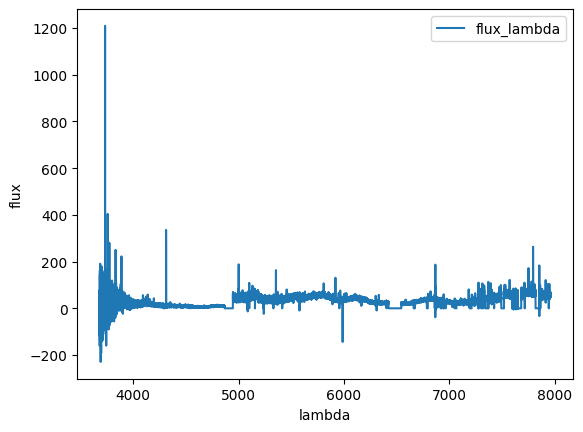

In [14]:
data.plot(x='lambda',y='flux_lambda', kind='line')
plt.xlabel('lambda')
plt.ylabel('flux')

## Unify

### Preliminars

In [38]:
import os
import re
import pickle
import numpy as np
import pandas as pd

from astropy.time import Time

os.makedirs(name='data/spectra',exist_ok=True)

In [16]:
fidx = 0
file_name = os.listdir(path='wiserep_data_')[fidx]

file_name.split(sep='_')

['PTF11kx', '2011-03-14', '07-43-00', 'Keck1', 'HIRES', 'PTF.ascii']

In [50]:
PATH_input = "./wiserep_data_/"
file = 'SN2007af_2007-04-10_09-30-14_Lick-3m_KAST_UCB-SNDB.flm'
file_split = file.split(sep='_')[3:]
with open(PATH_input+file, 'r') as infile:
    content = infile.readlines()
    for line in content:
        new_line = line.strip() + "\t"+"".join(file_split)
        print(new_line)

3314.00     0.881592	Lick-3mKASTUCB-SNDB.flm
3316.00      1.09214	Lick-3mKASTUCB-SNDB.flm
3318.00      1.41875	Lick-3mKASTUCB-SNDB.flm
3320.00      1.06171	Lick-3mKASTUCB-SNDB.flm
3322.00      1.15199	Lick-3mKASTUCB-SNDB.flm
3324.00      1.37899	Lick-3mKASTUCB-SNDB.flm
3326.00      1.39913	Lick-3mKASTUCB-SNDB.flm
3328.00     0.996488	Lick-3mKASTUCB-SNDB.flm
3330.00      1.02375	Lick-3mKASTUCB-SNDB.flm
3332.00      1.09254	Lick-3mKASTUCB-SNDB.flm
3334.00      1.18037	Lick-3mKASTUCB-SNDB.flm
3336.00     0.767522	Lick-3mKASTUCB-SNDB.flm
3338.00     0.504210	Lick-3mKASTUCB-SNDB.flm
3340.00     0.788058	Lick-3mKASTUCB-SNDB.flm
3342.00      1.11258	Lick-3mKASTUCB-SNDB.flm
3344.00      1.34688	Lick-3mKASTUCB-SNDB.flm
3346.00      1.35904	Lick-3mKASTUCB-SNDB.flm
3348.00      1.18972	Lick-3mKASTUCB-SNDB.flm
3350.00      1.50718	Lick-3mKASTUCB-SNDB.flm
3352.00      1.34215	Lick-3mKASTUCB-SNDB.flm
3354.00      1.48585	Lick-3mKASTUCB-SNDB.flm
3356.00      1.62145	Lick-3mKASTUCB-SNDB.flm
3358.00   

### Functions

In [56]:
PATH_input = './wiserep_data/'
PATH_output = './data/spectra/'

In [75]:
def types_sn_files(path_input=PATH_input):

    """Return a dictionary with all names of the spectra names files
    
    Parameters: 
    -----------
    path_input -> src: folder where there are the spectra.

    Returns:
    -----------
    SN_Dict -> dict: Dictionary with all names of SN
    """

    all_files = [files for files in os.listdir(path=path_input)]

    # Select just those begin with SNLS
    SNLS_list_files = [file for file in all_files if file.startswith('SNLS')]     
    SNLS_list_names = [snname.split('_')[0] for snname in SNLS_list_files]
    SNLS_list_names = set(SNLS_list_names)
    
    # Select whose that begin with other prefix
    other_SN_list_files = [file for file in all_files if (file.startswith('2MASS') or not file.startswith('SN'))]
    other_SN_list_files = [file for file in other_SN_list_files if not file[1].isdigit()]
    other_SN_names = [snname.split('_')[0] for snname in other_SN_list_files]
    other_SN_names = set(other_SN_names)

    # Select SN that begins with SN but not continue with the year
    no_SNSNLS_list_files = [file for file in all_files if file.startswith('SN')] 
    no_SNSNLS_list_files = [file for file in no_SNSNLS_list_files if not file.startswith('SNLS')] 
    no_SNSNLS_list_files = [file for file in no_SNSNLS_list_files if not file[2].isdigit()]
    no_SNSNLS_list_names = [snname.split('_')[0] for snname in no_SNSNLS_list_files]
    no_SNSNLS_list_names = set(no_SNSNLS_list_names)
    no_SNSNLS_list_names
    

    # Select SN that begins with SN and continue with the year.
    # This is the mosst complicated part.
    SN_list_files = [file for file in all_files if file.startswith('SN')] 
    SN_list_files = [file for file in SN_list_files if file not in SNLS_list_files ]         
    SN_list_files = [file for file in SN_list_files if file not in no_SNSNLS_list_files]         
    SN_list_names = [snname.split('_')[0] for snname in SN_list_files]
    SN_list_names = [snnameidx.replace('SN', '') for snnameidx in SN_list_names]
    SN_list_names = set(SN_list_names)

    SN_rest_list_files = [file for file in all_files if file not in SNLS_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in no_SNSNLS_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in other_SN_list_files]
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in SN_list_files]
    
    # Weird files
    weird_SN_list_files = [file for file in SN_rest_list_files if not file[3].isdigit()]
    #print(weird_SN_list_files)

    # Joining the big amount of SN
    SN_rest_list_files = [file for file in SN_rest_list_files if file not in weird_SN_list_files]
    SN_rest_names = [snname.split('_')[0] for snname in SN_rest_list_files]
    SN_rest_names = [snname for snname in SN_rest_names if snname not in SN_list_names]
    SN_rest_names = set(SN_rest_names)
    
    SN_names = SN_list_names | SN_rest_names
    
    # Weird files

    SN_dict = {'SN': SN_names,
               'SNLS': SNLS_list_names,
               'Other_SN': no_SNSNLS_list_names,
               'Other':other_SN_names,
               'Weird':weird_SN_list_files}

    return SN_dict

In [76]:
SN_dict = types_sn_files()

In [61]:
searching_file = '175_2456399.36'
searching_file in SN_dict['Weird']

False

In [63]:
def process_files2raw(sn_name, path_input=PATH_input, path_output=PATH_output, key_value=None):
    
    """Join all the spectra files in one

    Parameters:
    ------------

    Returns:
    ------------
    sn_name_raw.dat -> text file with the columns to be transformed in a dataframe
    
    """

    if key_value == None:
        return print('Error you need a key_value !!')

    if key_value == 'Weird':
        return print('This is a weird file')
        
    sn_pattern = re.compile(sn_name, re.IGNORECASE)
    print(sn_pattern)
    matching_files = []
    # Buscar archivos que coincidan con el patrón
    for file in os.listdir(path=path_input):
        if sn_pattern.search(file):
            matching_files.append(file)

    # Crear el archivo de salida utilizando el nombre base del patrón
    if key_value == 'SN':

        with open(path_output + f'SN{sn_name}_raw.dat', 'w') as f:
            for file in matching_files:
                instrument = file.split(sep='_')[3:]
                hour = file.split(sep='_')[2].replace('-',':')
                date = file.split(sep='_')[1]
                #print(instrument)
                with open(path_input + file, 'r') as infile:
                    content = infile.readlines()
                    for line in content:
                        if line.strip() and line.strip()[0].isdigit():
                            new_line = line.strip() + "\t" + "_".join(instrument) + "\t" + "T".join([date,hour])
                            f.write(new_line)
                            f.write('\n')
                infile.close()
        f.close()

    else:
        with open(path_output + f'{sn_name}_raw.dat', 'w') as f:
            for file in matching_files:
                instrument = file.split(sep='_')[3:]
                hour = file.split(sep='_')[2].replace('-',':')
                date = file.split(sep='_')[1]
                with open(path_input + file, 'r') as infile:
                    content = infile.readlines()
                    for line in content:
                        if line.strip() and line.strip()[0].isdigit():
                            new_line = line.strip() + "\t" + "_".join(instrument) + "\t" + "T".join([date,hour])
                            f.write(new_line)
                            f.write('\n')
                infile.close()
        f.close()

In [74]:
file_raw_list = [file for file in os.listdir(path='./data/spectra/') if '_raw' in file]
file_data_list = [file for file in os.listdir(path='./data/spectra/') if '_raw' not in file] 
file_raw_list_name = [file_name.split('_')[0] for file_name in file_raw_list]

len(file_raw_list)

2359

In [6]:
def process_file2dataframe(sn_name, path_input=PATH_output, path_output=PATH_output, key_value=None):
    
    """Takes the raw.dat file and it corvert to 'dataframe'
    
    
    """
    
    if key_value == None:
        return print('Error u need a key_value !!')
        
    if key_value == 'Weird':
        return print('This is a weird file')

    data = []

    if key_value == 'SN':
        # Leer el archivo línea por línea
        with open(f"{path_output}SN{sn_name}_raw.dat", 'r') as file:
            for line in file:
                # Dividir la línea en columnas
                columns = re.split(r'\s+', line.strip())
                # Si la fila tiene menos de 4 columnas, agregar NaN y permutar
                if len(columns) == 4:
                    columns.append(np.nan)  # Añadir NaN
                    columns[2], columns[-1] = columns[-1], columns[2]  # Permutar la tercera con la cuarta columna
                    columns[3], columns[-1] = columns[-1], columns[3]  # Permutar la tercera con la cuarta columna
                # Si la fila tiene más de 4 columnas (esto no debería pasar según tu descripción), la truncamos
                if len(columns) > 4:
                    columns = columns[:6]
                data.append(columns)

        # Crear un DataFrame con los datos procesados
        headers = ['lambda', 'flux_lambda', 'e_flux_lambda', 'instrument', 'date']
        df = pd.DataFrame(data, columns=headers)
        # Asegurarse de que la columna 'date' sea de tipo string
        df['date'] = df['date'].astype(str)
        # Convertir cada fecha a MJD
        df['mjd'] = df['date'].apply(lambda x: Time(x).mjd)

        # Eliminar la columna date
        df = df.drop('date', axis=1)
        df = df.reindex(columns=['mjd','lambda', 'flux_lambda', 'e_flux_lambda', 'instrument'])
        # Guardar el DataFrame resultante en un nuevo archivo
        df.to_csv(f"{path_output}SN{sn_name}.dat", index=False, header=True, na_rep='nan')
        os.remove(f"{path_output}SN{sn_name}_raw.dat")

    else: 
        with open(f"{path_output}{sn_name}_raw.dat", 'r') as file:
            for line in file:
                # Dividir la línea en columnas
                columns = re.split(r'\s+', line.strip())
                # Si la fila tiene menos de 4 columnas, agregar NaN y permutar
                if len(columns) == 4:
                    columns.append(np.nan)  # Añadir NaN
                    columns[2], columns[-1] = columns[-1], columns[2]  # Permutar la tercera con la cuarta columna
                    columns[3], columns[-1] = columns[-1], columns[3]  # Permutar la tercera con la cuarta columna
                # Si la fila tiene más de 4 columnas (esto no debería pasar según tu descripción), la truncamos
                if len(columns) > 4:
                    columns = columns[:6]
                data.append(columns)

        # Crear un DataFrame con los datos procesados
        headers = ['lambda', 'flux_lambda', 'e_flux_lambda', 'instrument', 'date']
        df = pd.DataFrame(data, columns=headers)
        # Asegurarse de que la columna 'date' sea de tipo string
        df['date'] = df['date'].astype(str)
        # Convertir cada fecha a MJD
        df['mjd'] = df['date'].apply(lambda x: Time(x).mjd)

        # Eliminar la columna date
        df = df.drop('date', axis=1)
        df = df.reindex(columns=['mjd','lambda', 'flux_lambda', 'e_flux_lambda', 'instrument'])
        # Guardar el DataFrame resultante en un nuevo archivo
        df.to_csv(f"{path_output}{sn_name}.dat", index=False, header=True, na_rep='nan')
        os.remove(f"{path_output}{sn_name}_raw.dat")

In [7]:
def running_merge_spectra(sn_name, path_input=PATH_input, path_output=PATH_output, key_value=None):
    
    if sn_name.startswith('SN') and key_value == 'SN':
        sn_name = sn_name.replace('SN', '')
    #print(sn_name)
    if key_value == None:
        return print('Error u need a key_value !!')
        
    if key_value == 'Weird':
        return print('This is a weird file')
    
    if key_value == 'SN':
        #if f'SN{sn_name}.dat' in os.listdir(path='./data/spectra/'):
        #    return print('File already exist')
        
        #else:
            #print('Running SN',sn_name)
        try:
            #print('Obtaining the raw data ...')
            process_files2raw(sn_name=sn_name,path_output=PATH_output,key_value=key_value)
        except:
            print('Supernova SN',sn_name,'| Error in raw')
        try:
            #print('Obtaining the dataframe ....')
            process_file2dataframe(sn_name=sn_name, path_input=PATH_output, path_output=PATH_output,key_value=key_value)
        except:
            print('Supernova SN',sn_name,'| Error in dataframe')

    else:
        #if f'{sn_name}.dat' in os.listdir(path='./data/spectra/'):
        #    return print('File already exist')
        
        #else:
            #print('Running SN',sn_name)
        try:
            #print('Obtaining the raw data ...')
            process_files2raw(sn_name=sn_name,path_output=PATH_output,key_value=key_value)
        except:
            print('Supernova ',sn_name,'| Error in raw')
        try:
            #print('Obtaining the dataframe ....')
            process_file2dataframe(sn_name=sn_name, path_input=PATH_output, path_output=PATH_output,key_value=key_value)
        except:
            print('Supernova ',sn_name,'| Error in dataframe')

In [8]:
SN_dict_keys = list(SN_dict.keys())
SN_dict_keys

['SN', 'SNLS', 'Other_SN', 'Other', 'Weird']

In [9]:
SN_dict['SN']

set()

In [11]:
# Ya estuvo other, 0
# Ya estuvo other, 1
# Ya estuvo other, 2
# Ya estuvo other, 3
# Ya estuvo other, 4
key_value = SN_dict_keys[0]
count = 0
total = len(SN_dict[key_value])
for sn_name in SN_dict[key_value]:
    if count % 10 == 0:
        print(f'{count}/{total}')
    running_merge_spectra(sn_name=sn_name, path_output=PATH_output,key_value=str(key_value))
    count += 1

0/883
Supernova SN 2016dsg | Error in dataframe
Supernova SN 2016fmb | Error in dataframe
Supernova SN 2005ek | Error in dataframe
Supernova SN 2016bru | Error in dataframe
Supernova SN 2016I | Error in dataframe
10/883
Supernova SN 2016cvk | Error in dataframe
Supernova SN 2016hax | Error in dataframe
Supernova SN 2005lz | Error in dataframe
20/883
Supernova SN 2005H | Error in dataframe
Supernova SN 2005ls | Error in dataframe
Supernova SN 2005I | Error in dataframe
Supernova SN 2016iyk | Error in dataframe
Supernova SN 2016gsd | Error in dataframe
Supernova SN 2016hpw | Error in dataframe
Supernova SN 2016ghp | Error in dataframe
30/883
Supernova SN 2016cwh | Error in dataframe
Supernova SN 2005mc | Error in dataframe
40/883
Supernova SN 2005as | Error in dataframe
Supernova SN 2016gsb | Error in dataframe
Supernova SN 2016hgn | Error in dataframe
Supernova SN 2006ax | Error in dataframe
Supernova SN 2016gfr | Error in dataframe
Supernova SN 2016blq | Error in dataframe
Supernova SN

## Plotting

In [65]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
all_files = os.listdir(path='./data/spectra/')
all_files = [file for file in all_files if "_raw" not in file]


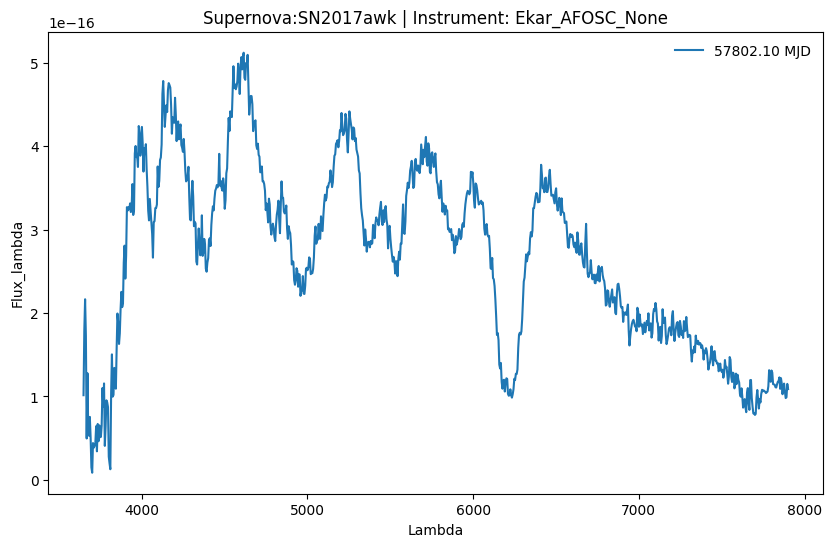

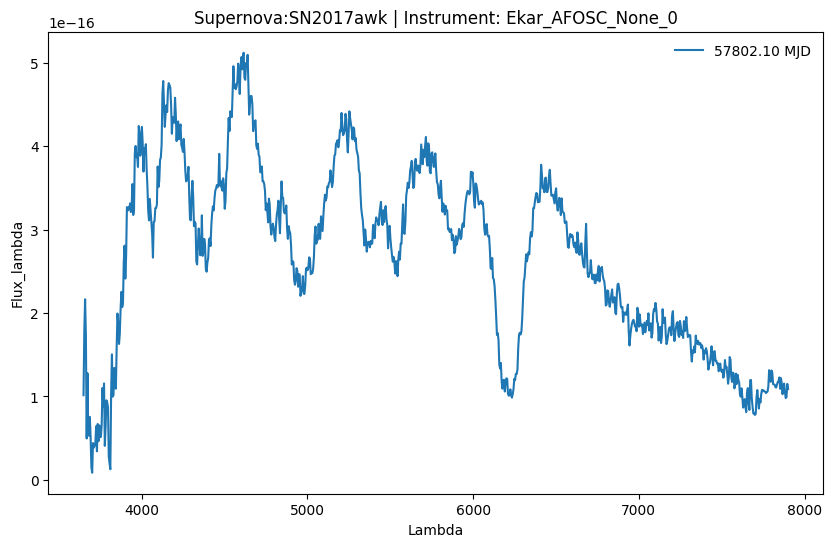

In [135]:
sn_name = random.choice(all_files)
sn_name = 'SN2017awk.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

""


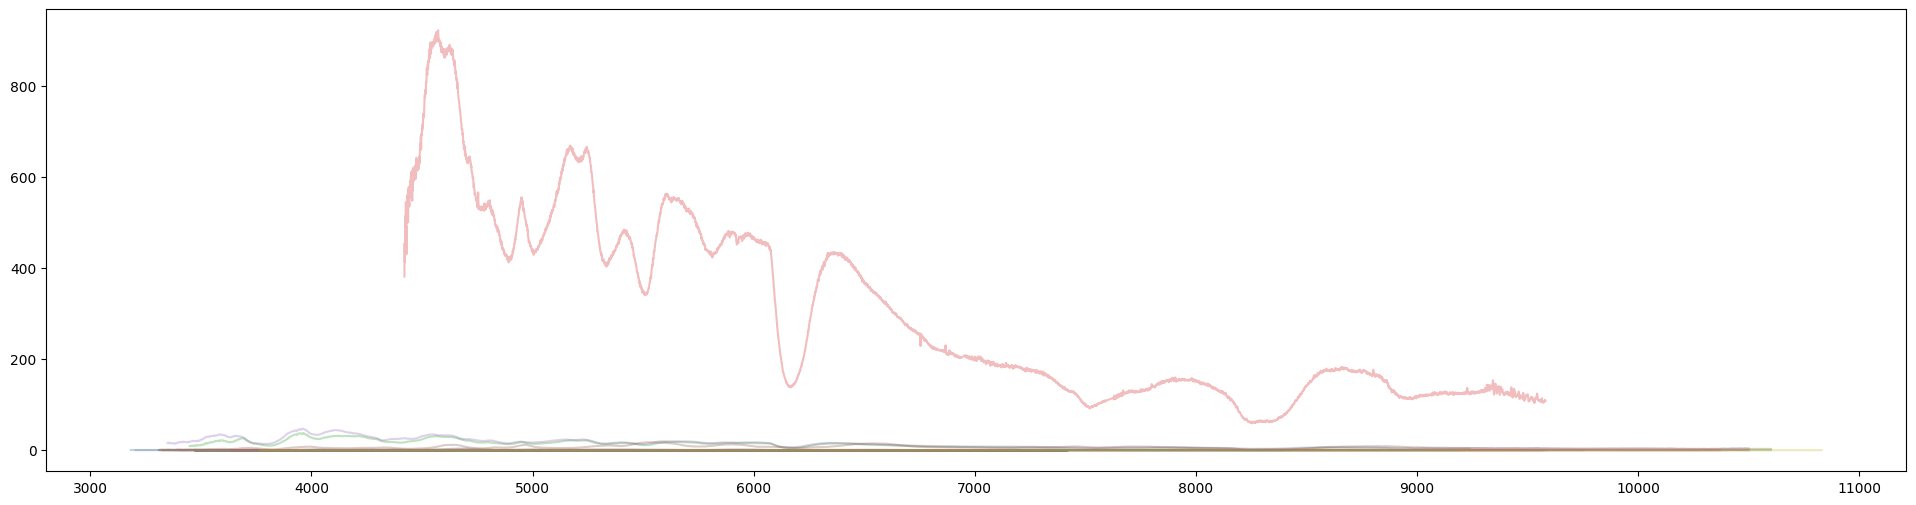

In [128]:
def plotobject(df):
    df.groupby(["date"]).apply(
        lambda df:ax.plot(df['lambda'], df['flux'], alpha=0.3))  
fig, ax = plt.subplots(figsize=(24, 6))
data.groupby('instrument').apply(plotobject)

## Master DataSet

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate

In [32]:
PATH_input = './data/spectra/'

all_files = [file for file in os.listdir(path=PATH_input) if '_raw' not in file]
print(f'The total amount of Supernovae ready to process is:',len(all_files))

The total amount of Supernovae ready to process is: 16476


I am using the data from LSST

In [42]:


lambda_grid_min = 3061.21  # u_filter min
lambda_grid_max = 10999.99 # y_filter max 
nlambda_grid    = 1525
# Here we crete an equal spacing 
lambda_grid_array = np.logspace(np.log10(lambda_grid_min),np.log10(lambda_grid_max),nlambda_grid)

In [43]:
c = 3e10
dlambda = lambda_grid_array[1:] - lambda_grid_array[:-1]
res = dlambda / (lambda_grid_array[:-1] + lambda_grid_array[1:])  * c
res

#1536 pts

array([12589409.70455341, 12589409.70454034, 12589409.7045552 , ...,
       12589409.70453845, 12589409.70456939, 12589409.70454183])

dlambda = lss[1:] - lss[:-1]

res = dlambda / lss[-1] * velocidad de la luz

la velocidad es constante

In [52]:
file = all_files[2]
data = pd.read_csv(PATH_input+file)
data.head()

,mjd,lambda,flux_lambda,e_flux_lambda,instrument
0,57122.0,3100.026,2.133000e-17,1.402000e-16,P200_DBSP_iPTF.ascii
1,57122.0,3101.074,7.831000e-17,1.339000e-16,P200_DBSP_iPTF.ascii
2,57122.0,3102.121,-9.795000e-17,1.371000e-16,P200_DBSP_iPTF.ascii
3,57122.0,3103.169,-8.190000e-17,1.332000e-16,P200_DBSP_iPTF.ascii
4,57122.0,3104.216,6.802000e-17,1.281000e-16,P200_DBSP_iPTF.ascii


In [65]:
for file in all_files:
    data = pd.read_csv(PATH_input+file)
    if len(data) > 10000:
        print(file)
        break

SN2006dv.dat


In [73]:
data_instrument = data.groupby('instrument')
data_instrument
for int, group in data_instrument:
    group.to_csv(f'{sn_name}_{int}.csv')

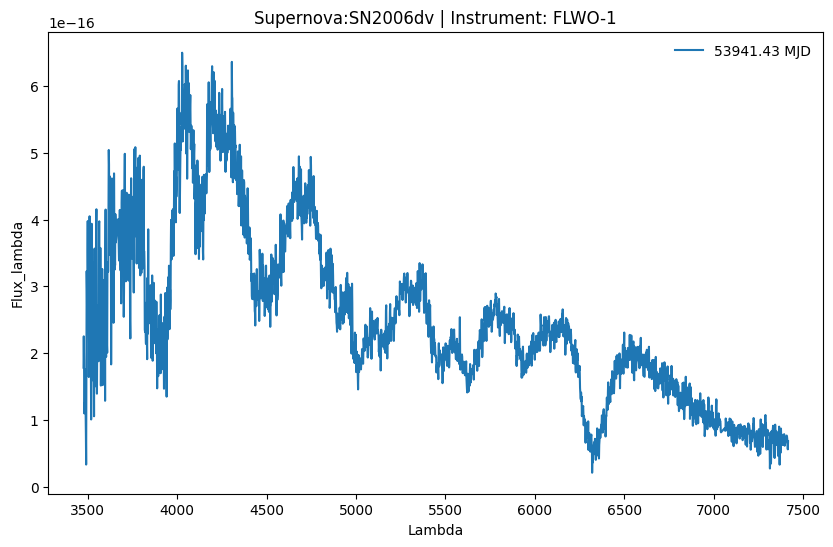

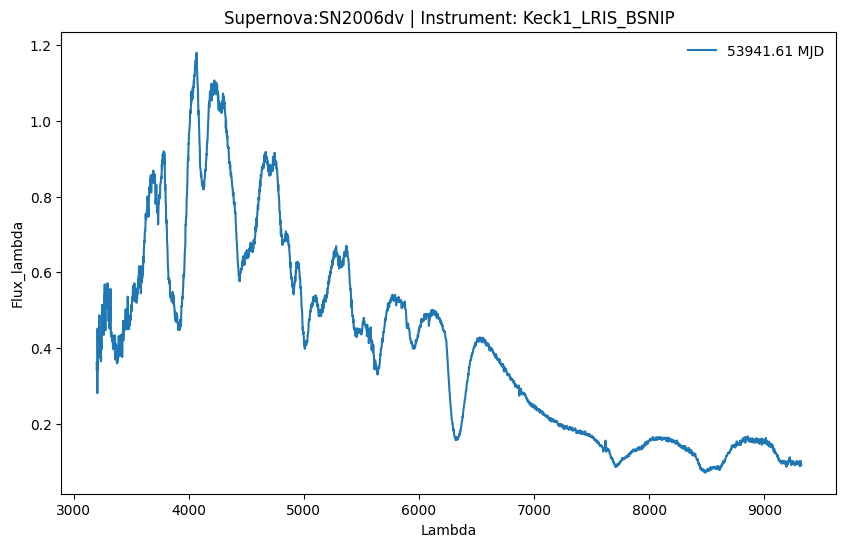

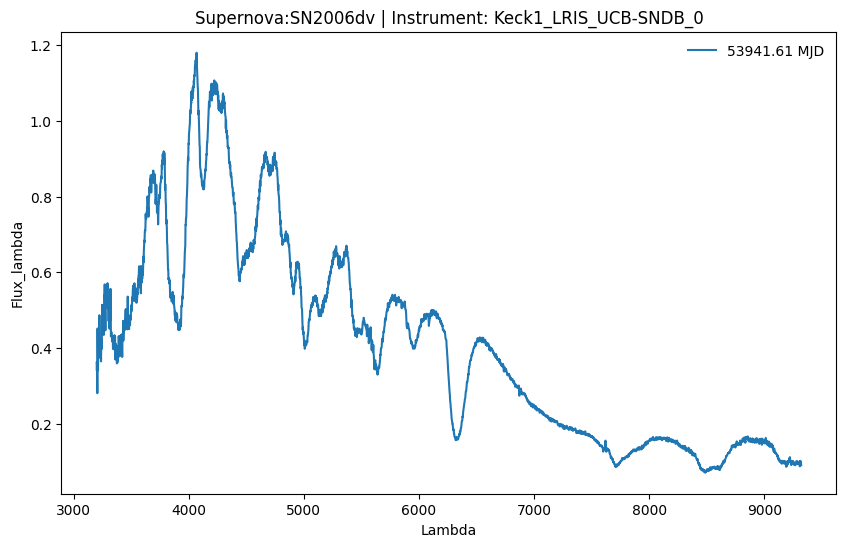

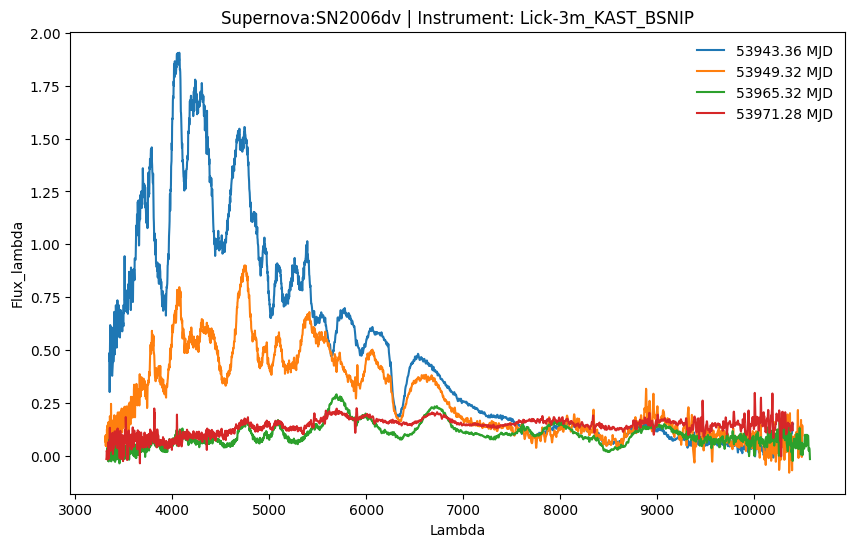

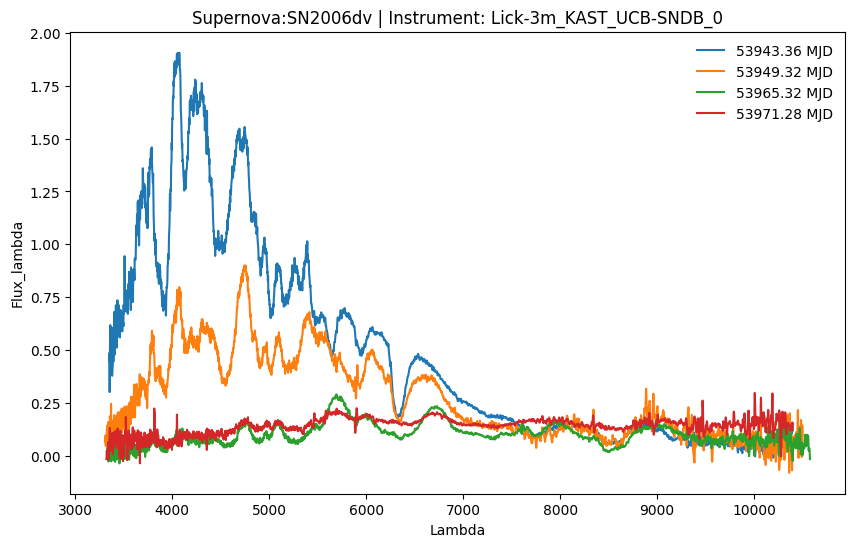

In [66]:
sn_name = 'SN2006dv.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

x_lambda_array = data['lambda']
y = data['flux_lambda']
f = interpolate.interp1d(x_lambda_array, y, fill_value=np.nan)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

In [68]:
x_lambda_array = lambda_grid_array
x_new = [x_lambd for x_lambd in x_lambda_array if data['lambda'].min() < x_lambd < data['lambda'].max()]
y = np.array(data['flux_lambda'])
f = interpolate.interp1d(x, y, fill_value=np.nan)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [55]:
x = lambda_grid_array
y = np.array(data['flux_lambda'])
f = interpolate.interp1d(x, y, fill_value=np.nan)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [50]:

data

,mjd,lambda,flux_lambda,e_flux_lambda,instrument
0,57122.0,3100.026,2.133000e-17,1.402000e-16,P200_DBSP_iPTF.ascii
1,57122.0,3101.074,7.831000e-17,1.339000e-16,P200_DBSP_iPTF.ascii
2,57122.0,3102.121,-9.795000e-17,1.371000e-16,P200_DBSP_iPTF.ascii
3,57122.0,3103.169,-8.190000e-17,1.332000e-16,P200_DBSP_iPTF.ascii
4,57122.0,3104.216,6.802000e-17,1.281000e-16,P200_DBSP_iPTF.ascii
...,...,...,...,...,...
5309,57122.0,10244.428,-2.463000e-17,1.434000e-17,P200_DBSP_iPTF.ascii
5310,57122.0,10245.974,2.369000e-17,1.622000e-17,P200_DBSP_iPTF.ascii
5311,57122.0,10247.518,4.805000e-20,1.507000e-17,P200_DBSP_iPTF.ascii
5312,57122.0,10249.064,2.543000e-17,1.550000e-17,P200_DBSP_iPTF.ascii


In [ ]:
def interpolate_flux_eflux(data: pd.DataFrame, lambda_array: np.array) -> :

In [4]:
def obtain_flux_eflux(data, lambda_lenght):
    #mjd = []
    flambda, eflambda = [], []

    f
    for i in range(len(lambda_lenght)-1):
        flux    = data[(lambda_lenght[i] < data['lambda']) & (data['lambda'] < lambda_lenght[i+1])]['flux_lambda'].values
        eflux   = data[(lambda_lenght[i] < data['lambda']) & (data['lambda'] < lambda_lenght[i+1])]['e_flux_lambda'].values

        f
        
        if len(flux) == 0:
            flambda.append(np.nan)
        else:
            flambda.append(flux)
        if len(eflux) == 0:
            eflambda.append(np.nan)
        else:
            eflambda.append(eflux)

    lambda_min = data['lambda'].min()
    lambda_max = data['lambda'].max()

    return flambda, eflambda, lambda_min, lambda_max

In [5]:
# Lista para almacenar los resultados
def arrange_spectra(sn_name,data,oid):
    results = []
    for inst_name, inst_group in data.groupby('instrument'):
        for mjd, mjd_group in inst_group.groupby('mjd'):
            flambda, eflambda, lambda_data_min, lambda_data_max = obtain_flux_eflux(mjd_group, lambda_grid_lenght)
            
            data_flux = {
                'oid': oid,
                'snname':sn_name,
                'instrument': inst_name,
                'mjd': mjd,
                'lambda_grid_min': lambda_grid_min,
                'lambda_grid_max': lambda_grid_max,
                'nlambda_grid': nlambda_grid,
                'lambda_data_min': lambda_data_min,
                'lambda_data_max': lambda_data_max,
                'flux_lambda': list(flambda),
                'e_flux_lambda':list(eflambda)}
            results.append(data_flux)

            oid += 1

    unique_table = pd.DataFrame(results)
    return unique_table, oid

In [31]:
len(all_files)

16476

In [32]:
master_dataframe = pd.DataFrame()
indx_ini = 11000
indx_fin = 12000
oid = 11000 - 1
for file in all_files[indx_ini:indx_fin]:
    sn_name = file.split('.')[0]
    data = pd.read_csv(PATH_input+file)
    result_table, oid = arrange_spectra(sn_name=sn_name, data=data,oid=oid)
    master_dataframe = pd.concat([master_dataframe, result_table])
    oid = oid

UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [30]:
master_dataframe.to_csv(f'./master_spectra_table_{indx_ini}_{indx_fin}.cvs')

In [34]:
master_dataframe_list = [file for file in os.listdir(path='./') if file.startswith("master_spectra")]
master_dataframe_list

['master_spectra_table_15000_16000.cvs',
 'master_spectra_table_16000_17000.cvs',
 'master_spectra_table_6000_7000.cvs',
 'master_spectra_table_2000_3000.cvs',
 'master_spectra_table_4000_5000.cvs',
 'master_spectra_table_7000_8000.cvs',
 'master_spectra_table_10000_11000.cvs',
 'master_spectra_table_0_1000.cvs',
 'master_spectra_table_12000_13000.cvs',
 'master_spectra_table_8000_9000.cvs',
 'master_spectra_table_9000_10000.cvs',
 'master_spectra_table_14000_15000.cvs',
 'master_spectra_table_5000_6000.cvs',
 'master_spectra_table_1000_2000.cvs',
 'master_spectra_table_13000_14000.cvs',
 'master_spectra_table_3000_4000.cvs']

In [39]:
# master_dataframe = pd.DataFrame()
# for master_spectra_table in master_dataframe_list:
#     data = pd.read_csv(master_spectra_table)
#     master_dataframe = pd.concat([master_dataframe, data])

In [40]:
#master_dataframe.to_csv(f'./master_spectra_table_main.cvs')

## Working with the DataFrame

In [14]:
master_dataframe = pd.read_csv('master_spectra_table_main.cvs')
master_dataframe = master_dataframe.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
master_dataframe.head()

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,18829,SN2021rfs,LT_SPRAT_TNS.dat,59396.185532,3061.21,10999.99,1000,4020.000000,7994.400000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,18830,SN2021rfs,P60_SEDM_TNS.ascii,59395.422824,3061.21,10999.99,1000,3776.700000,9223.300000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,18831,SN2021agmw,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,59574.304691,3061.21,10999.99,1000,3650.047852,9245.227452,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,18832,SN2021acfg,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,59516.229665,3061.21,10999.99,1000,3655.047852,9250.227452,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,18833,SN2021ytn,UH88_SNIFS_TNS.dat,59474.575694,3061.21,10999.99,1000,3402.860000,9099.860000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [24]:
sn_dataframe = master_dataframe[master_dataframe['snname'] == 'SN2021rfs']
#sn_dataframe = sn_dataframe[0]
sn_dataframe

,oid,snname,instrument,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,18829,SN2021rfs,LT_SPRAT_TNS.dat,59396.185532,3061.21,10999.99,1000,4020.0,7994.4,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,18830,SN2021rfs,P60_SEDM_TNS.ascii,59395.422824,3061.21,10999.99,1000,3776.7,9223.3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


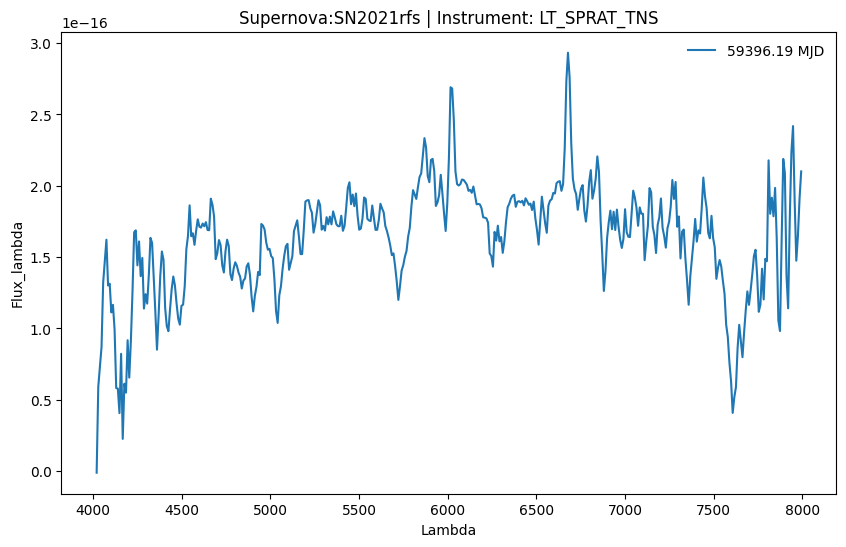

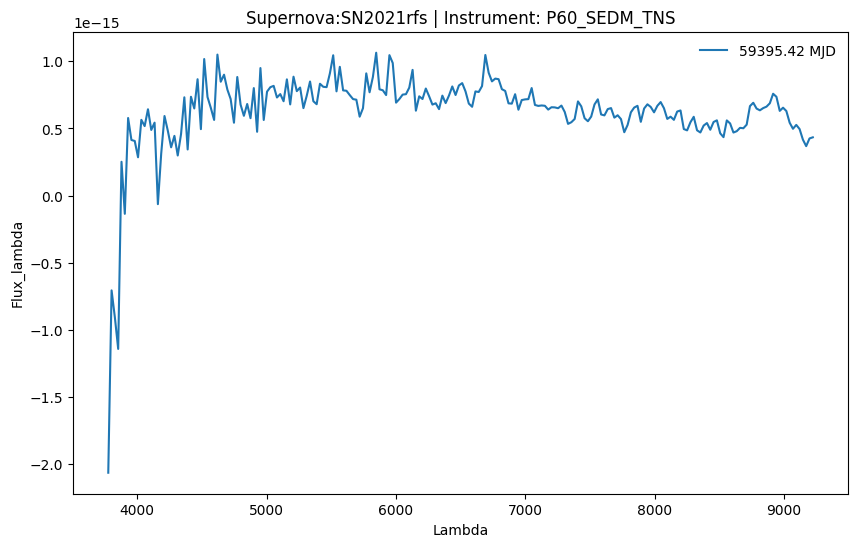

In [26]:
sn_name = 'SN2021rfs.dat'
data = pd.read_csv('./data/spectra/'+sn_name)

def plotobject(df,sn_name, inst_name):
  fig, ax = plt.subplots(figsize=(10, 6))
  for mjd_date, group_df in df.groupby('mjd'):
       ax.plot(group_df['lambda'], group_df['flux_lambda'], label=f'{mjd_date:.2f} MJD')
  ax.legend(frameon=False)
  ax.set_xlabel('Lambda')
  ax.set_ylabel('Flux_lambda')
  ax.set_title('Supernova:'+sn_name.split(".")[0]+" | Instrument: "+inst_name.split(".")[0])
  

data_instrument = data.groupby('instrument')
for inst_name, group in data_instrument:
    plotobject(group, sn_name=sn_name, inst_name=inst_name)

KeyError: "None of [Index([ 3061.210000000001, 3065.1319747482976, 3069.0589742697775,\n       3072.9910050021085,  3076.928073391197,  3080.870185891207,\n       3084.8173489645815, 3088.7695690820337,  3092.726852722567,\n        3096.689206373495,\n       ...\n       10873.961558232872, 10887.893109039678,  10901.84250873321,\n       10915.809780181144, 10929.794946280512, 10943.798029957687,\n       10957.819054168347,  10971.85804189765, 10985.915016160197,\n       10999.990000000013],\n      dtype='float64', length=1000)] are in the [columns]"

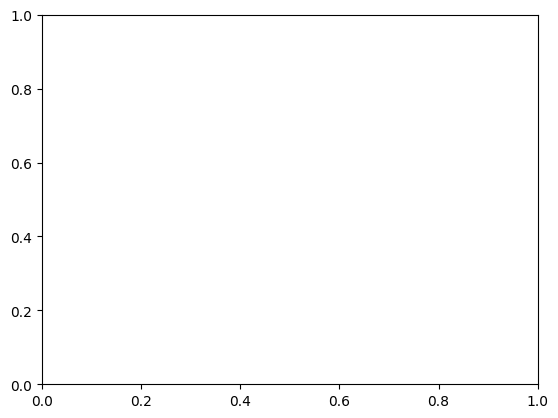

In [27]:
fig, ax = plt.subplots()
sn_dataframe.plot(x='flux_lambda',y=lambda_grid_lenght)


## Importing AstroDash

In [1]:
import tensorflow as tf

2024-06-17 11:09:54.449094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 11:09:55.786851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
class ConvNetLayer(object):
    def __init__(self, N, ntypes, imWidth, imWidthReduc):
        self.N = N
        self.ntypes = ntypes
        self.imWidth = imWidth
        self.imWidthReduc = imWidthReduc

    def build_layer(self, prevHPool, prevNumFeatures, numFeatures):
        W_conv = self._weight_variable([5, 5, prevNumFeatures, numFeatures])
        b_conv = self._bias_variable([numFeatures])
        h_conv = tf.nn.relu(self._conv2d(prevHPool, W_conv) + b_conv)
        h_pool = self._max_pool_2x2(h_conv)
        # print(h_pool)

        return h_pool

    def connect_layers(self, h_pool, numFeatures, layerNum):
        W_fc = self._weight_variable(
            [int(self.imWidthReduc / layerNum * self.imWidthReduc / layerNum * numFeatures), 1024])
        b_fc = self._bias_variable([1024])
        h_pool_flat = tf.reshape(h_pool,
                                 [-1, int(self.imWidthReduc / layerNum * self.imWidthReduc / layerNum * numFeatures)])
        h_fc = tf.nn.relu(tf.matmul(h_pool_flat, W_fc) + b_fc)

        return h_fc

    def dropout(self, h_fc):
        keep_prob = tf.placeholder(tf.float32)
        h_fc_drop = tf.nn.dropout(h_fc, keep_prob)

        return keep_prob, h_fc_drop

    def readout_layer(self):
        W_fc = self._weight_variable([1024, self.ntypes])
        b_fc = self._bias_variable([self.ntypes])

        return W_fc, b_fc

    def _weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def _bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def _conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def _max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
